In [2]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Load data from CSV file
file2 = pd.read_csv("../Output/With low Data .csv")

# Extract the columns from the data
file2=file2[file2['Target PPM']<=200]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


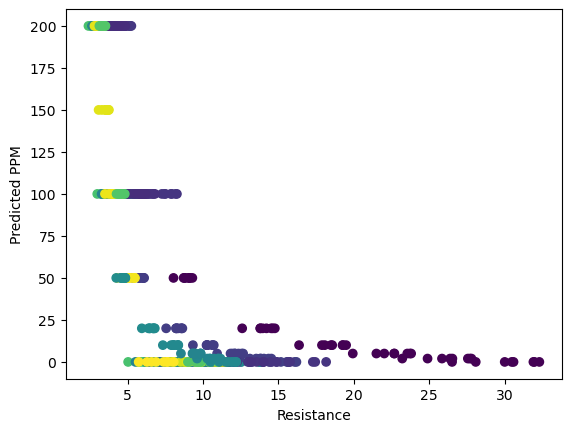

In [4]:
df = file2
plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
plt.show()

In [5]:
#
def funct(X, a, b, c,d):
    R, H = X
    return a*R**b+c*H*(a*R**b+c)+d
p0 = 1,1,.5,1
# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct, (xDataResistance,xDataRH), yDataTargetPPM, maxfev=1000000)

# Print the optimized parameters
print(popt)

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct((R_test,H_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):
    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct((df.loc[:, 'Resistance'],df.loc[:, 'RelativeHumidity']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

[-6.61985077e+00  7.46831276e-02  7.45782925e+00  1.02519028e+02]
42.28978582771285
The 95% Confidence Interval for 0 is (2.667614105701757, 13.906488449921293)
The 95% Confidence Interval for 200 is (146.11355831375792, 157.58902886995563)
The 95% Confidence Interval for 400 is (nan, nan)
The 95% Confidence Interval for 600 is (nan, nan)
The 95% Confidence Interval for 800 is (nan, nan)
The 95% Confidence Interval for 1000 is (nan, nan)


In [6]:
from scipy.optimize import OptimizeWarning
import numpy as np
from scipy.optimize import curve_fit
import itertools
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings

#For With low Data <=200
#Fitted function parameters: a=1447.290, b=-1.307, c=-0.006 d=-46.608
#The initial conditions to get this optimization were: [13  0 -5 10]
#RMSE: 30.885694364712467

# Ignore all warnings in the code
warnings.filterwarnings("ignore")

def funkEQ(X, a, b, c, d):
    R, H = X
    with np.errstate(over='ignore'):
        stuff=a*R**b+c*H*(a*R**b+c)+d
    return stuff

def optimize_parameters(p0):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            warnings.filterwarnings('ignore', category=OptimizeWarning)

            popt, pcov = curve_fit(funkEQ, (xDataResistance, xDataRH), yDataTargetPPM, p0=p0, maxfev=1000000)

        return (p0, popt, np.sum((yDataTargetPPM - funkEQ((xDataResistance, xDataRH), *popt))**2))
    except Exception as e:
        print(f"Error with parameters {p0}: {str(e)}")
        return None

np.random.seed(42)

# Number of points to generate
num_points = 10000000

# Generate num_points random points in 4 dimensions, bounded by [-20, 20]
initial_params = np.random.uniform(-20, 20, size=(num_points, 4))

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(optimize_parameters)(p) for p in tqdm(initial_params))

# Filter out None, NaN, and Infinity results
successful_results = [result for result in results
                      if result is not None
                      and not np.any(np.isnan(result[1]))
                      and not np.any(np.isinf(result[1]))]

init_params, fitted_params, residuals = zip(*successful_results)

# Rank the parameters by their residual and only keep the top 10
best_params = np.array(fitted_params)[np.argsort(residuals)[:10]]
best_init = np.array(init_params)[np.argsort(residuals)[:10]]
# The best parameters are the first in the sorted list
print('Fitted function parameters: a=%.3f, b=%.3f, c=%.3f d=%.3f' % (best_params[0][0], best_params[0][1], best_params[0][2], best_params[0][3]))

print('The initial conditions to get this optimization were: '+str(best_init[0]))

# Calculate RMSE for the best parameters
predictions = funkEQ((xDataResistance, xDataRH), *best_params[0])
rmse = np.sqrt(np.mean((yDataTargetPPM - predictions)**2))
print(f"RMSE: {rmse}")



  0%|          | 29580/10000000 [01:48<7:40:38, 360.74it/s]

KeyboardInterrupt: 

R-squared:  0.7035264745218965


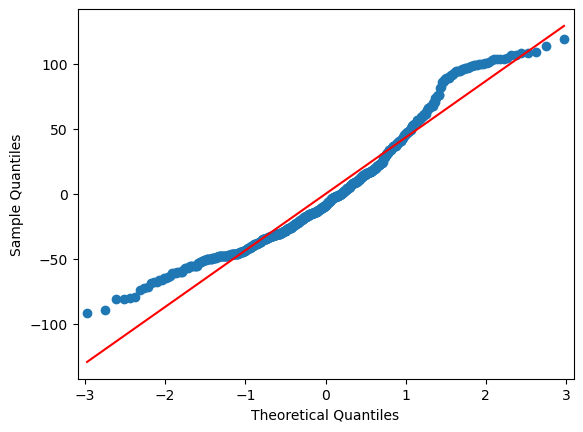

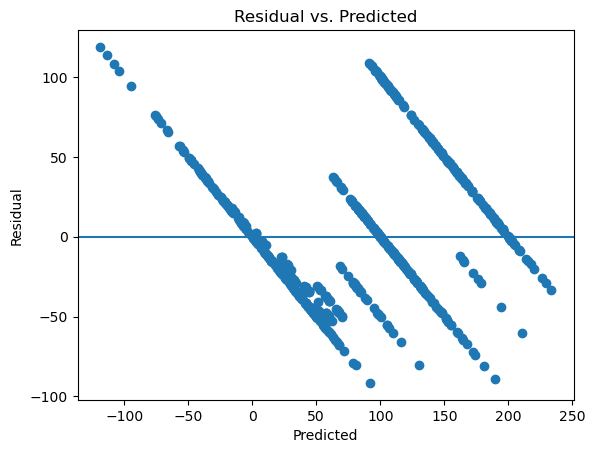

F-statistic: 534.7120466713499
p-value: 5.923042936002887e-178


In [30]:


y_pred = funkEQ((xDataResistance, xDataRH), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)


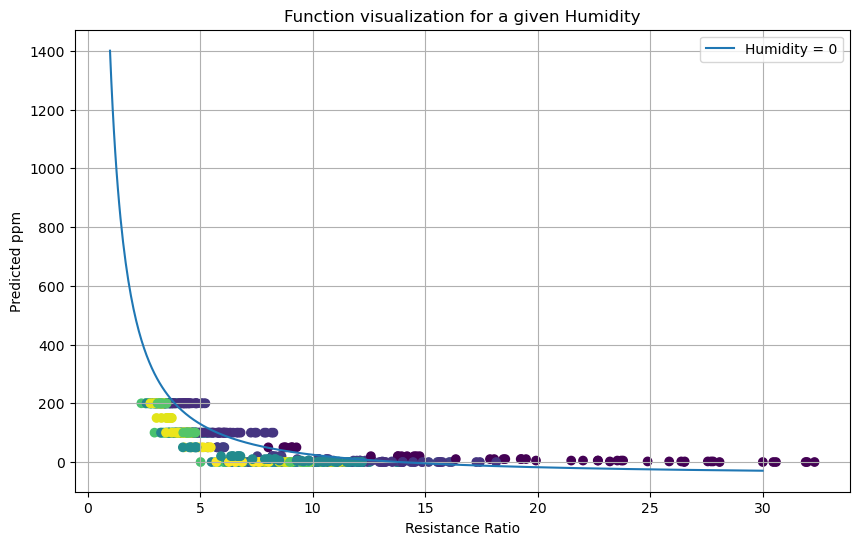

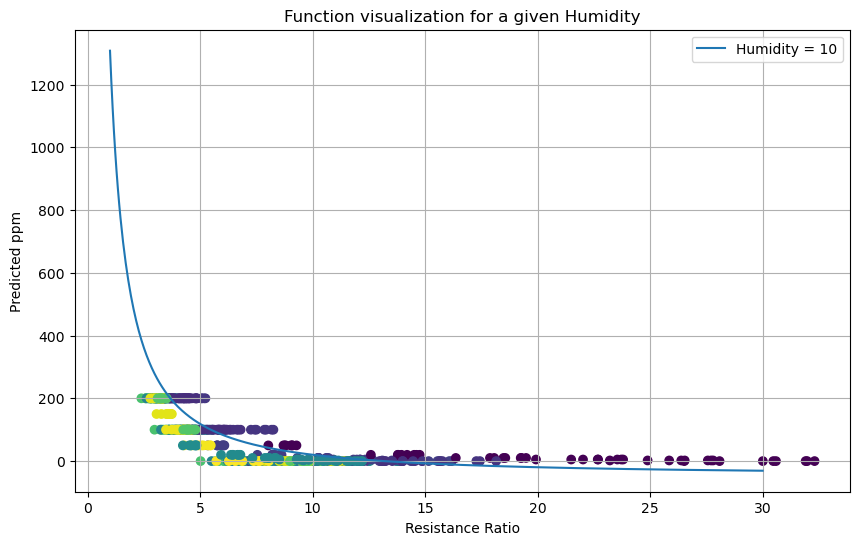

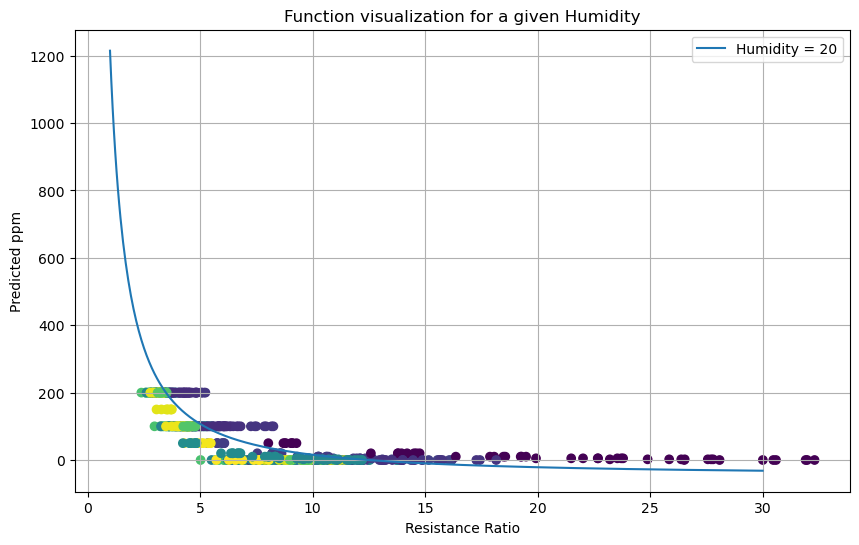

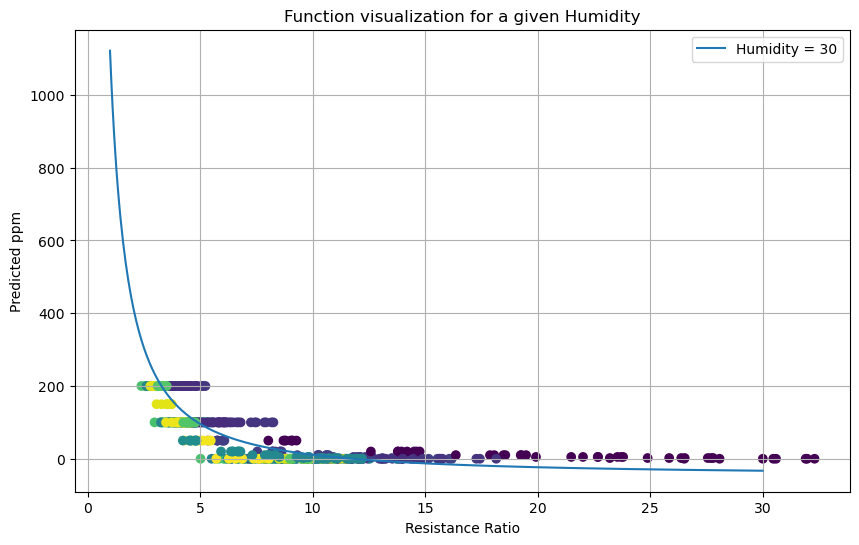

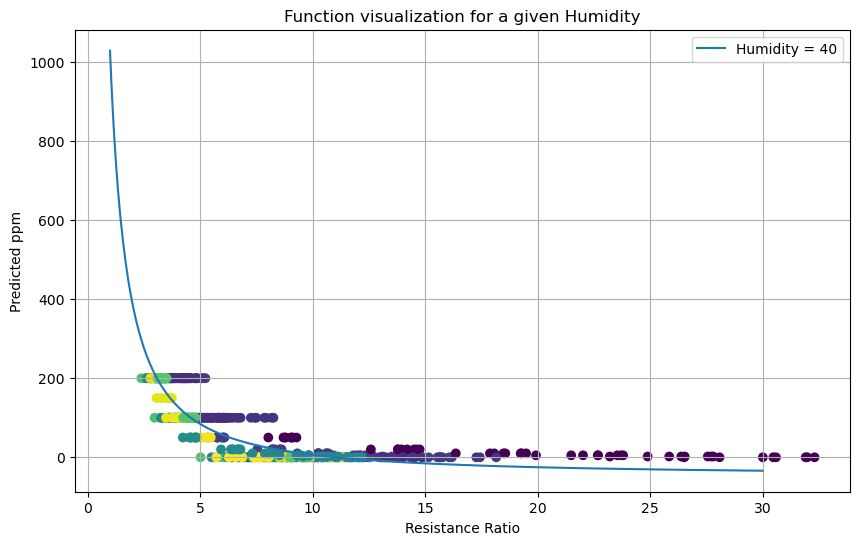

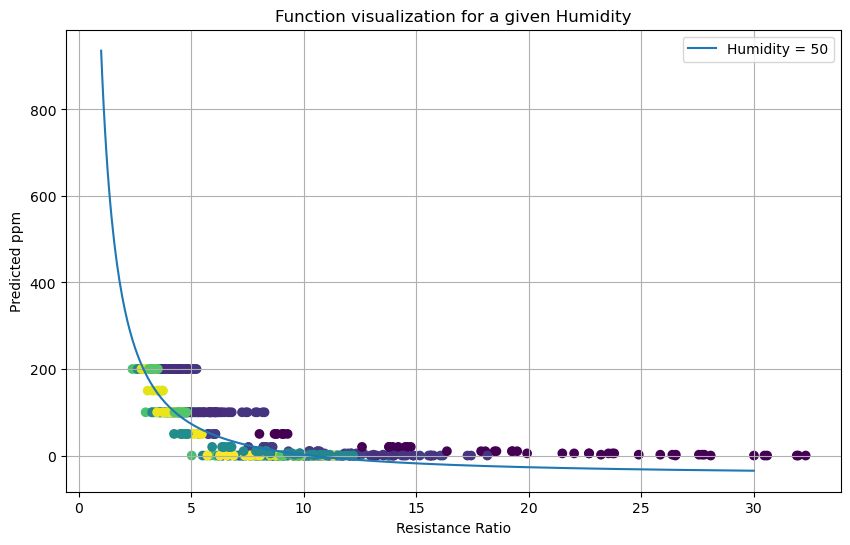

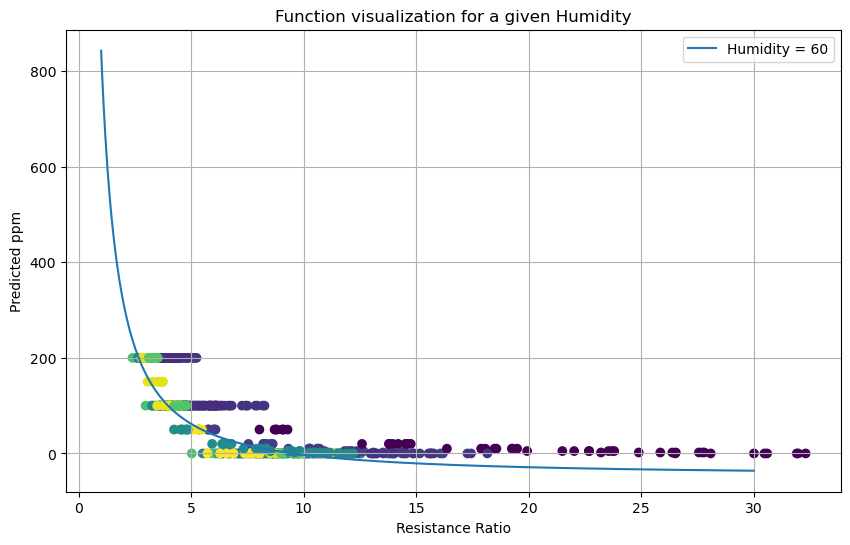

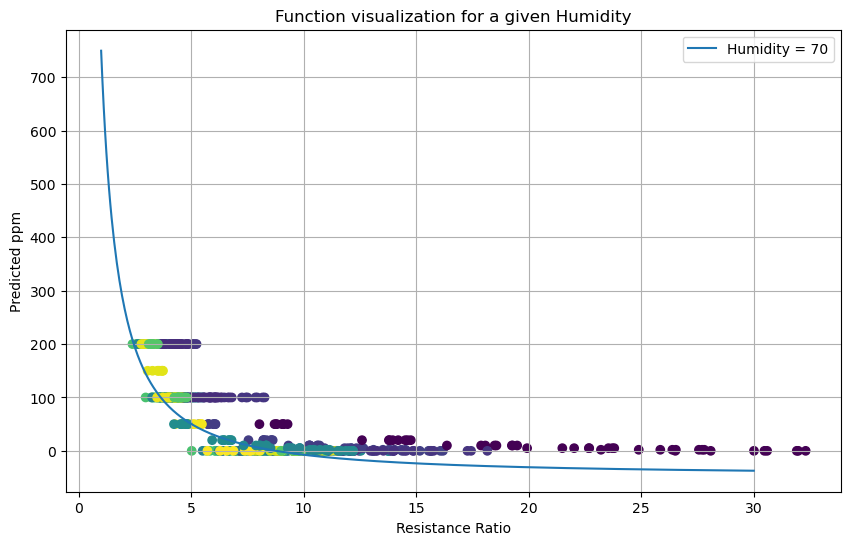

In [31]:
H = 5  # given humidity value

# R values
R = np.linspace(1, 30, num=500)
for H in [0,10,20,30,40,50,60,70]:
    # calculate function values
    y_values = [funct((r, H), *best_params[0]) for r in R]

    # plotting
    plt.figure(figsize=(10,6))
    plt.plot(R, y_values, label=f'Humidity = {H}')
    plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=df.loc[:, 'RelativeHumidity'])
    plt.xlabel('Resistance Ratio')
    plt.ylabel('Predicted ppm')
    plt.title('Function visualization for a given Humidity')
    plt.legend()
    plt.grid(True)
    plt.show()